In [16]:
# !git add -A
# !git status
# !git commit  -m "First commit of new branch"
# !git push -u origin feature/PR_data_processing


In [31]:
# Process PDF

In [32]:
# SBSA_AnnualReport.pdf

In [64]:
#───────────────────────────────────────────────────────────
# Invoke Lambda  ▸  companyFinancialStatementsAPIIngestion
#───────────────────────────────────────────────────────────
import json, boto3, os, pprint

# 1 ▸ Lambda client  (region inferred from current AWS config)
lambda_client = boto3.client("lambda")               # or: boto3.client("lambda", region_name="eu-west-1")

# 2 ▸ Build the event payload
event = {
    "queryName": "Toyota",   # name search term
    "period":    "annual",           # annual | quarter (aliases OK)
    # "exchange":  "OTC",            # optional – defaults via env var
    #
    # If your handler still expects the Bedrock wrapper fields, include them:
    # "actionGroup": "financial_statements",
    # "function":     "get_company_reports",
    # "parameters": [],
    # "messageVersion": "1.0"
}

# 3 ▸ Invoke the Lambda (synchronous)
response = lambda_client.invoke(
    FunctionName="companyFinancialStatementsAPIIngestion",  # ARN or name
    InvocationType="RequestResponse",                       # sync; use 'Event' for async
    Payload=json.dumps(event).encode("utf-8"),
)

# 4 ▸ Read and pretty-print the result
payload_bytes = response["Payload"].read()          # bytes → str → dict
result = json.loads(payload_bytes or "{}")

print("StatusCode:", response["StatusCode"])
pprint.pp(result)


StatusCode: 200
{'companyName': 'Toyota Motor Corporation',
 'ticker': 'TOYOF',
 'period': 'annual',
 's3Bucket': 's3-teamb-finreport',
 'files': ['parsed_results/TOYOTA_MOTOR_CORPORATION_INCOME.json',
           'parsed_results/TOYOTA_MOTOR_CORPORATION_BALANCE.json',
           'parsed_results/TOYOTA_MOTOR_CORPORATION_CASH.json']}


In [62]:
import json, boto3, pandas as pd

bucket = "s3-teamb-finreport"
key    = "parsed_results/TOYOTA_MOTOR_CORPORATION_INCOME.json"

# 1 ▸ download the JSON payload ------------------------------------------------
s3   = boto3.client("s3")
body = s3.get_object(Bucket=bucket, Key=key)["Body"]
payload = json.load(body)                 # -> dict with companyName & data[]

# 2 ▸ build a tidy dataframe ---------------------------------------------------
df = pd.DataFrame(payload["data"])        # each dict → one row
df.insert(0, "companyName", payload["companyName"])   # keep company name

# optional: make the date column real datetime & sort newest→oldest
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date", ascending=False).reset_index(drop=True)

# 3 ▸ inspect
print("Rows:", len(df), "  Columns:", len(df.columns))
display(df.head())                        # Jupyter will render the table nicely


Rows: 5   Columns: 39


,companyName,date,symbol,reportedCurrency,cik,fillingDate,acceptedDate,calendarYear,period,revenue,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
0,Toyota Motor Corporation,2025-03-31,TOYOF,JPY,0001094517,2025-06-18,2025-06-18 06:11:05,2025,FY,48036704000000,...,0.133535,1624835000000,4765086000000,0.099197,359.56,359.56,13252548000,13252456000,https://www.sec.gov/Archives/edgar/data/109451...,https://www.sec.gov/Archives/edgar/data/109451...
1,Toyota Motor Corporation,2024-03-31,TOYOF,JPY,0001094517,2024-06-25,2024-06-25 06:56:51,2024,FY,45095325000000,...,0.154453,1893665000000,4944933000000,0.109655,365.94,365.94,13512961000,13512848000,https://www.sec.gov/Archives/edgar/data/109451...,https://www.sec.gov/Archives/edgar/data/109451...
2,Toyota Motor Corporation,2023-03-31,TOYOF,JPY,0001094517,2023-06-30,2023-06-30 06:10:03,2023,FY,37154298000000,...,0.098743,1175765000000,2451318000000,0.065977,179.47,179.47,13658382000,13658382000,https://www.sec.gov/Archives/edgar/data/109451...,https://www.sec.gov/Archives/edgar/data/109451...
3,Toyota Motor Corporation,2022-03-31,TOYOF,JPY,0001094517,2022-06-23,2022-06-23 06:32:07,2022,FY,31379507000000,...,0.127170,1115918000000,2850110000000,0.090827,205.23,205.23,13887348000,13887659000,https://www.sec.gov/Archives/edgar/data/109451...,https://www.sec.gov/Archives/edgar/data/109451...
4,Toyota Motor Corporation,2021-03-31,TOYOF,JPY,0001094517,2021-06-24,2021-06-24 06:37:55,2021,FY,27214593000000,...,0.107749,649976000000,2245261000000,0.082502,160.65,158.93,13976440000,14206135000,https://www.sec.gov/Archives/edgar/data/109451...,https://www.sec.gov/Archives/edgar/data/109451...


Plotting 28 numeric features…


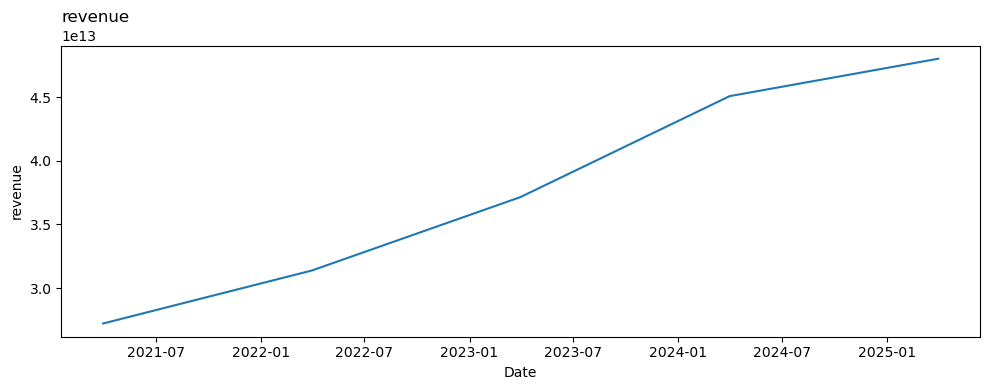

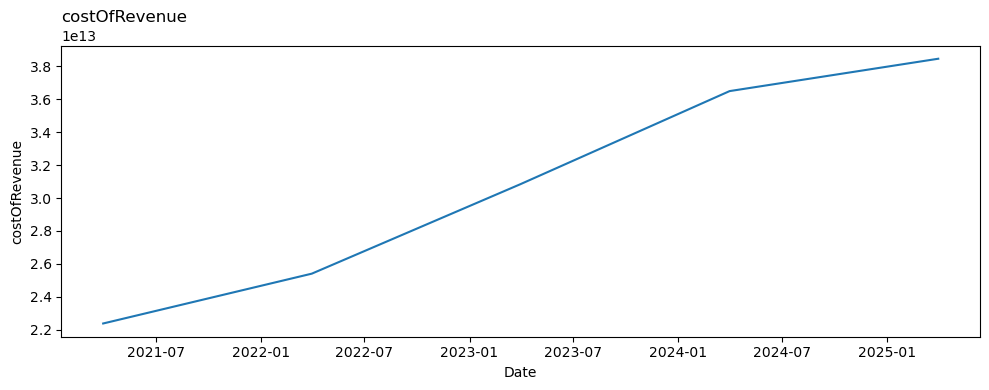

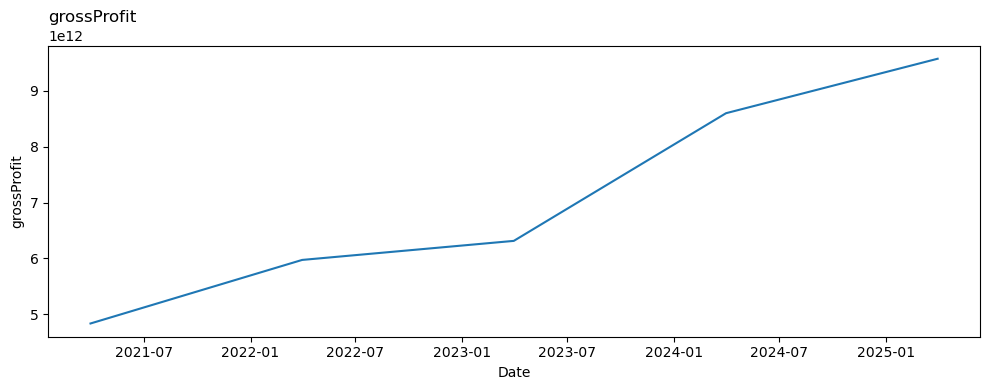

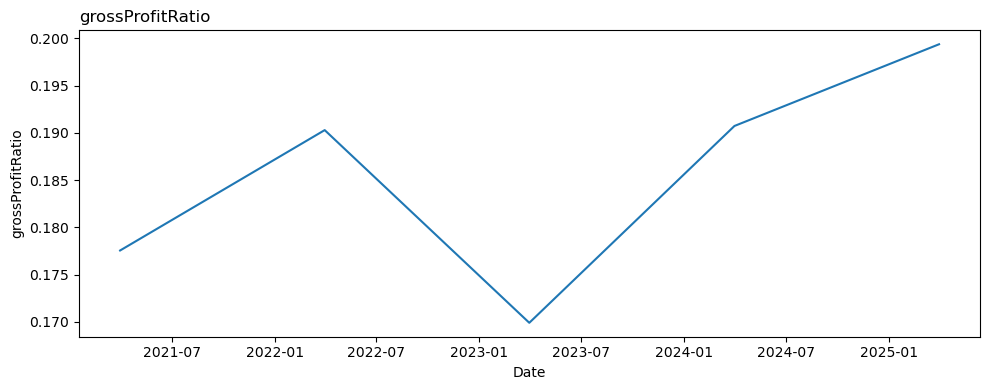

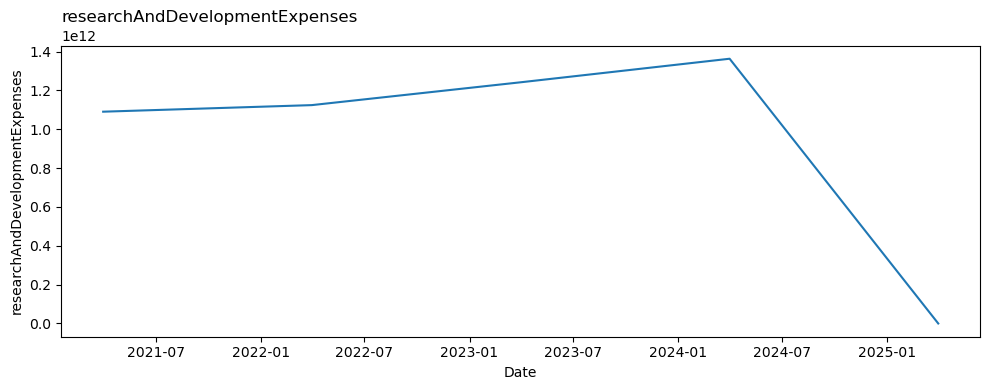

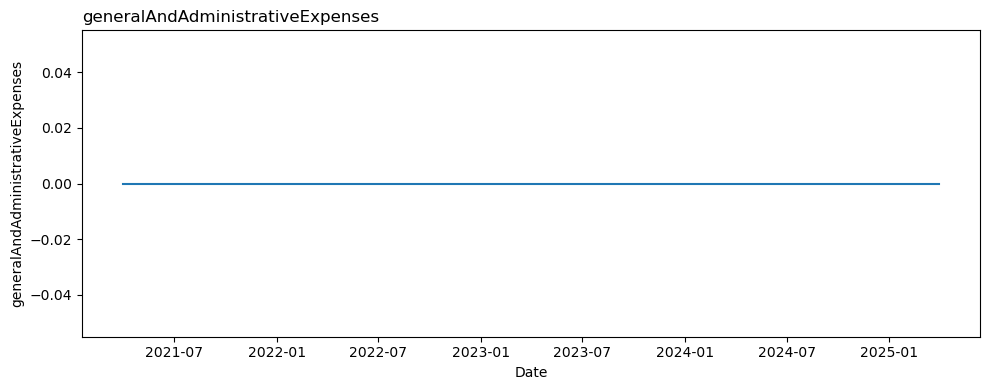

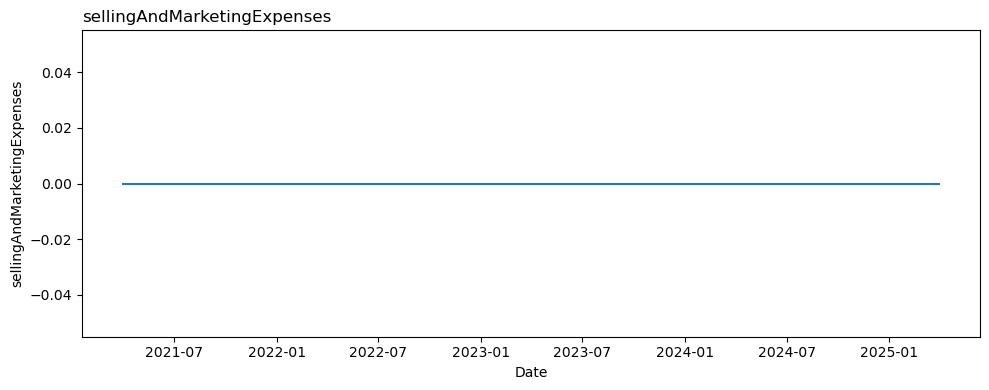

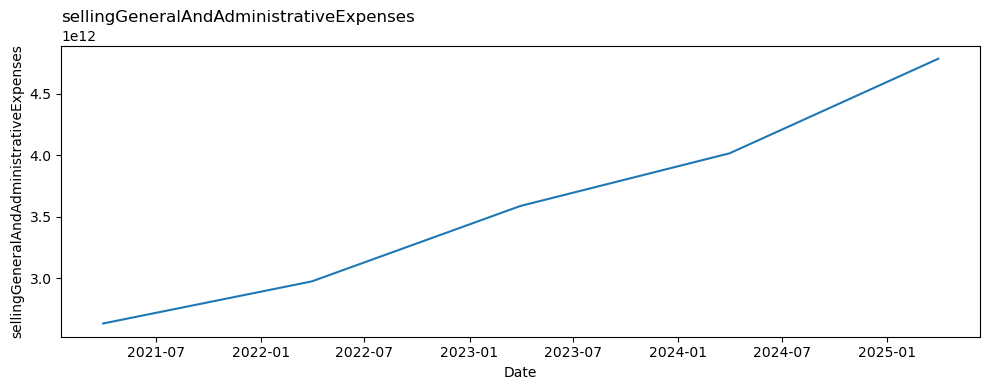

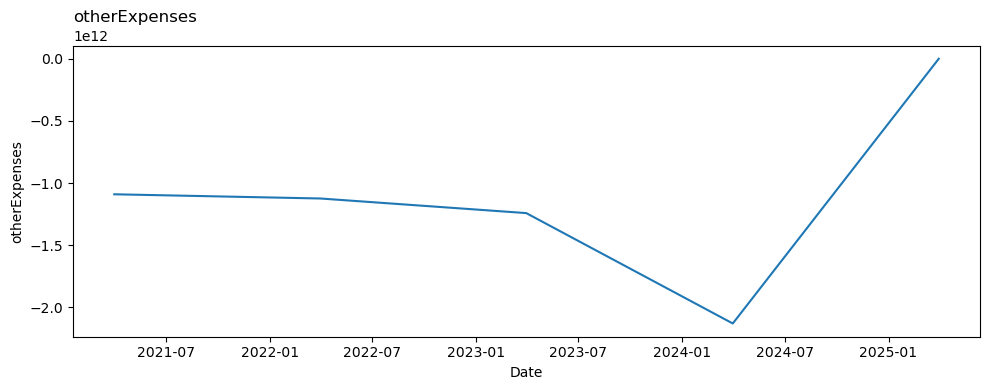

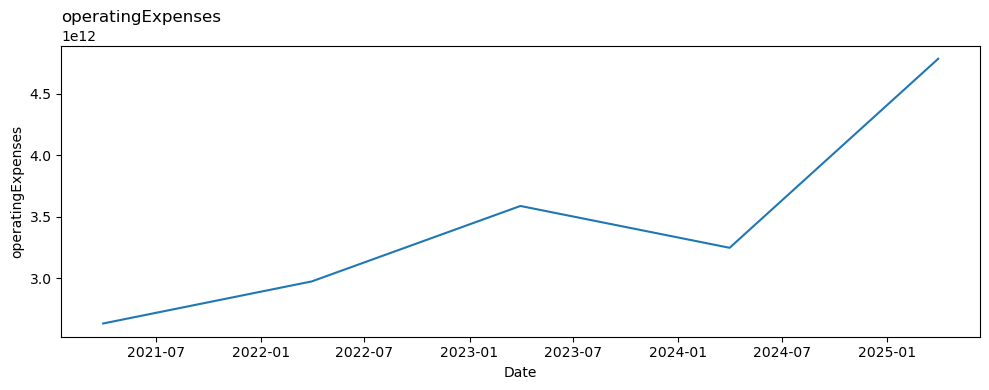

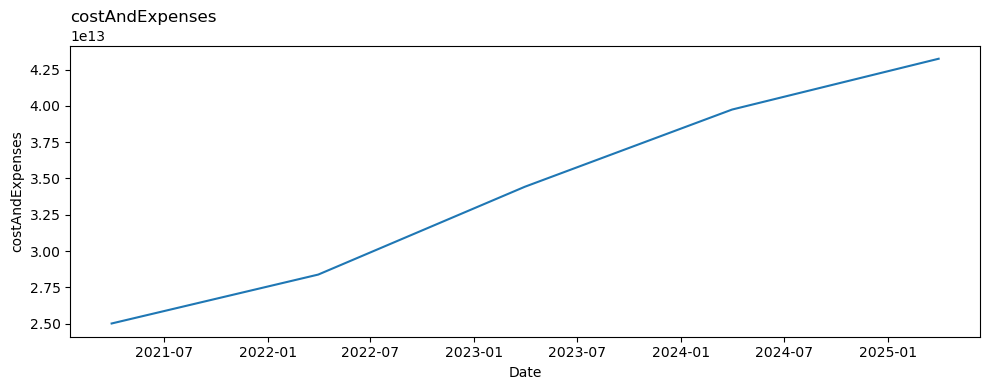

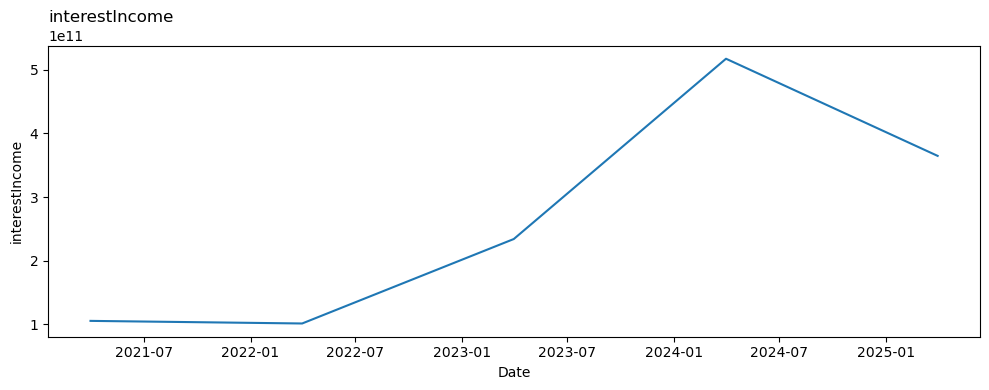

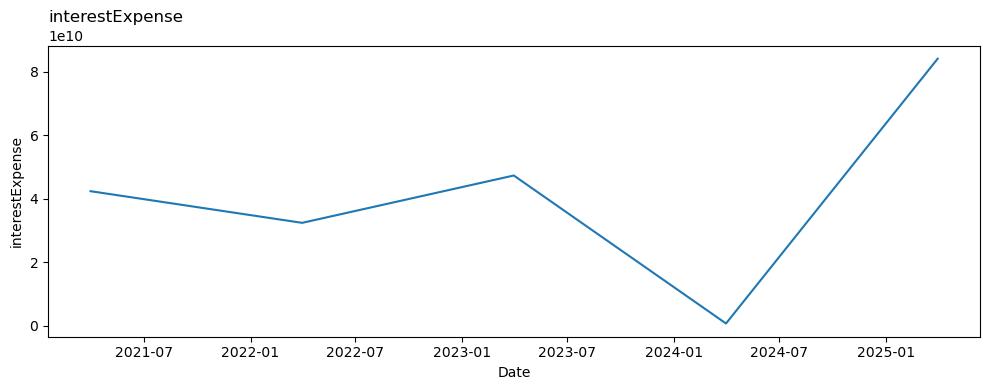

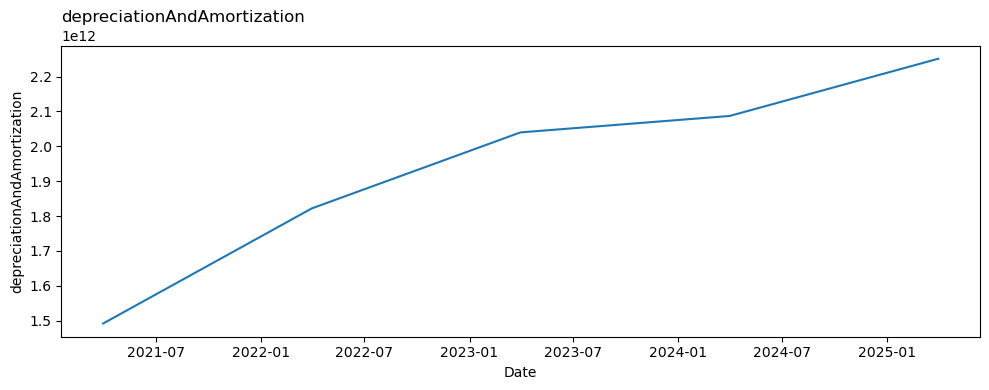

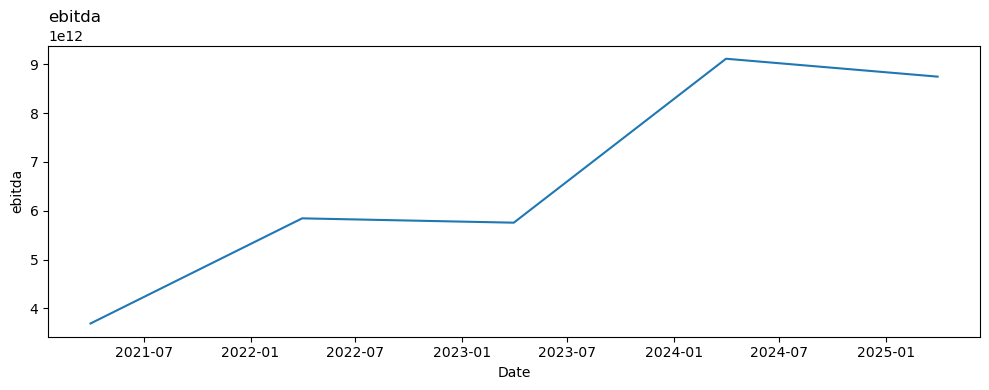

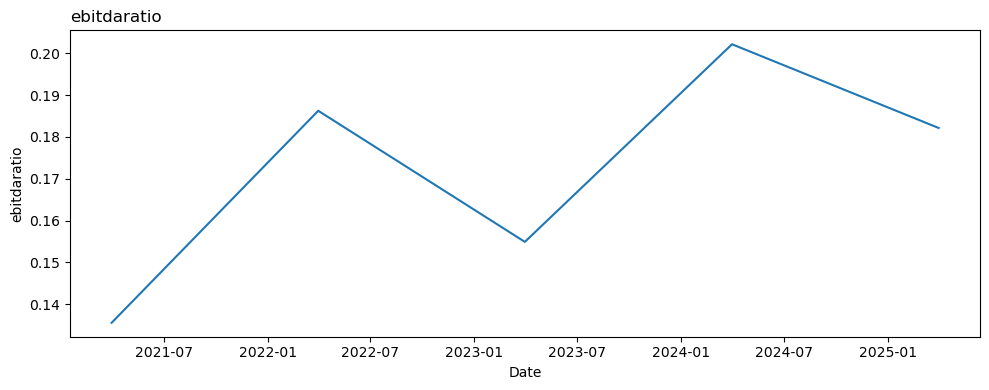

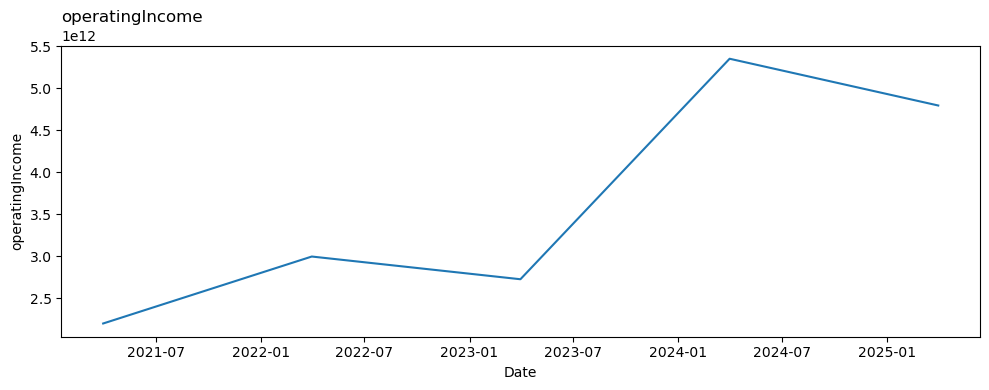

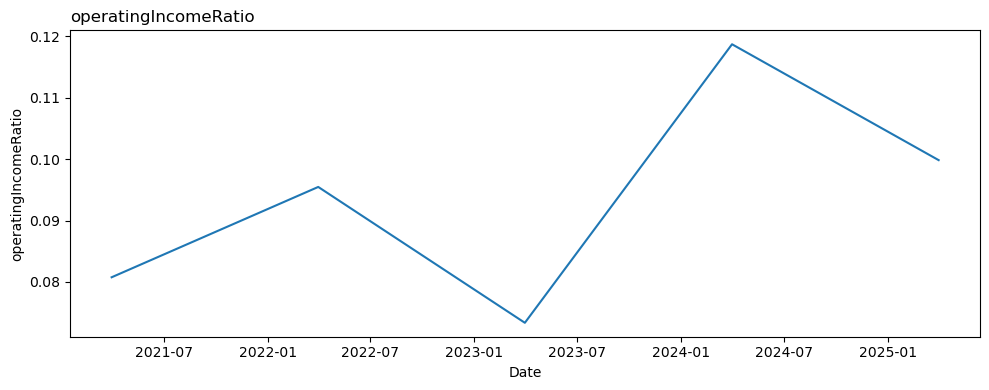

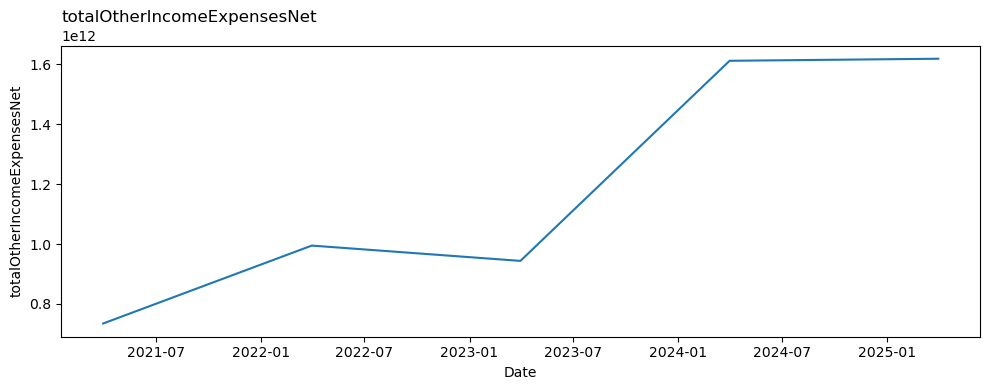

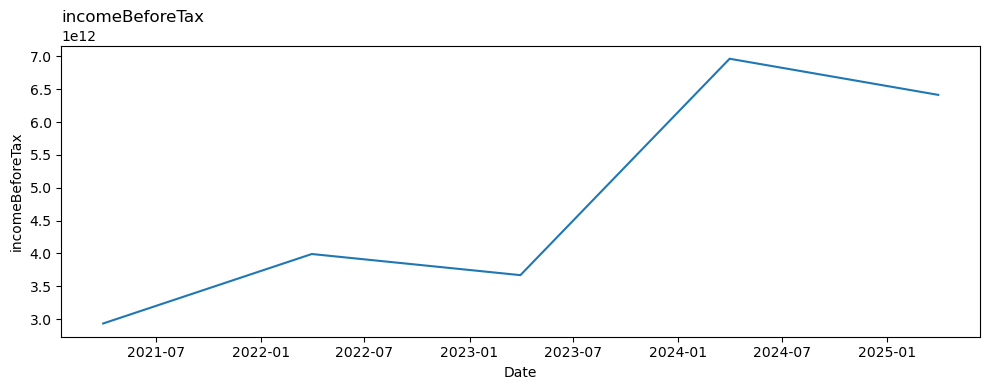

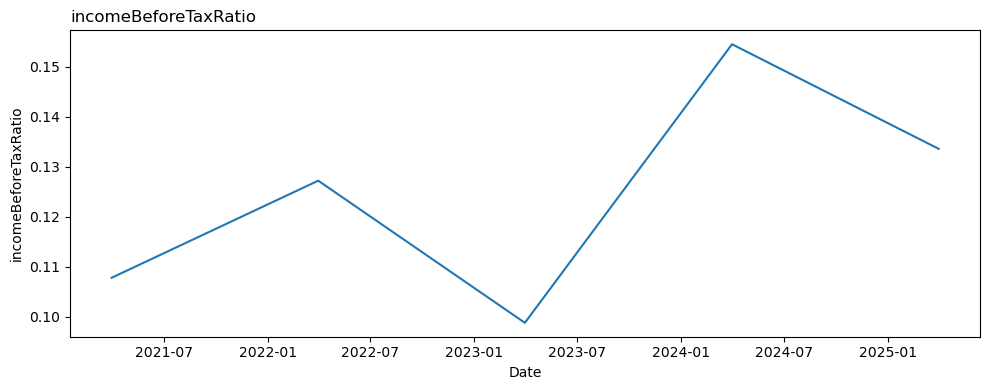

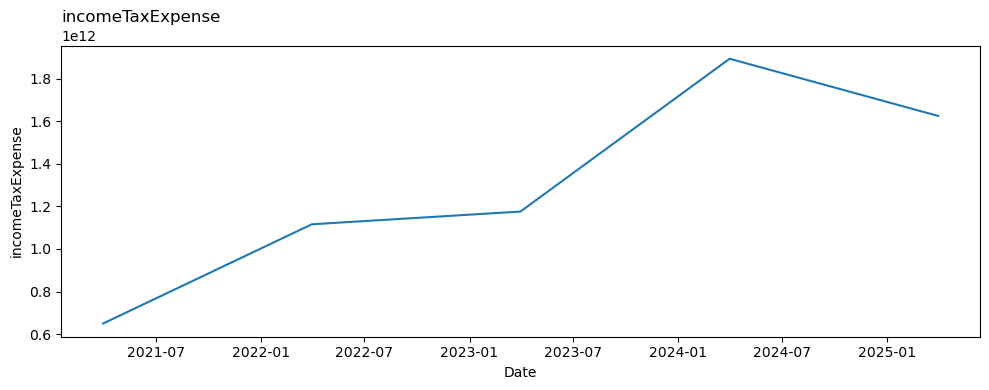

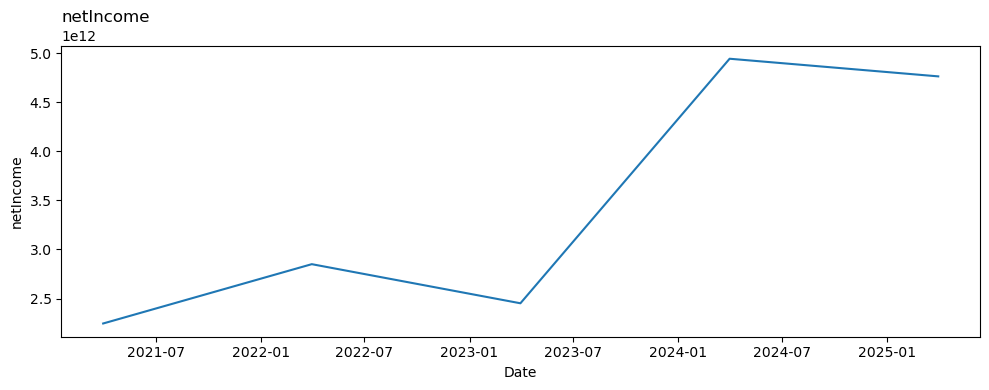

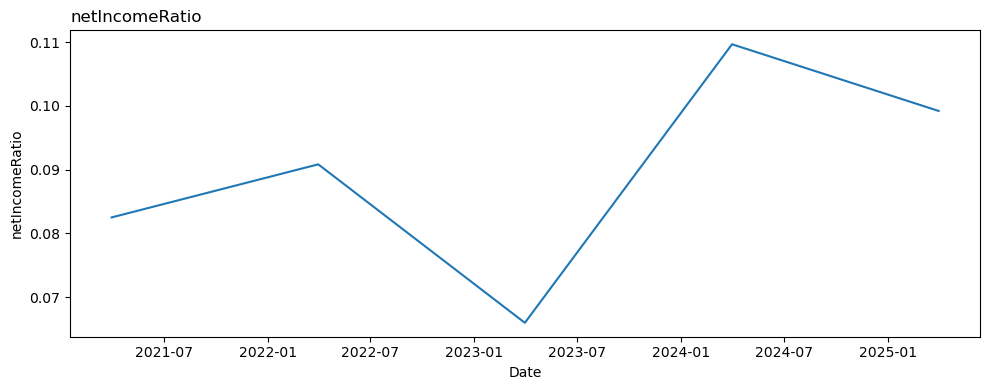

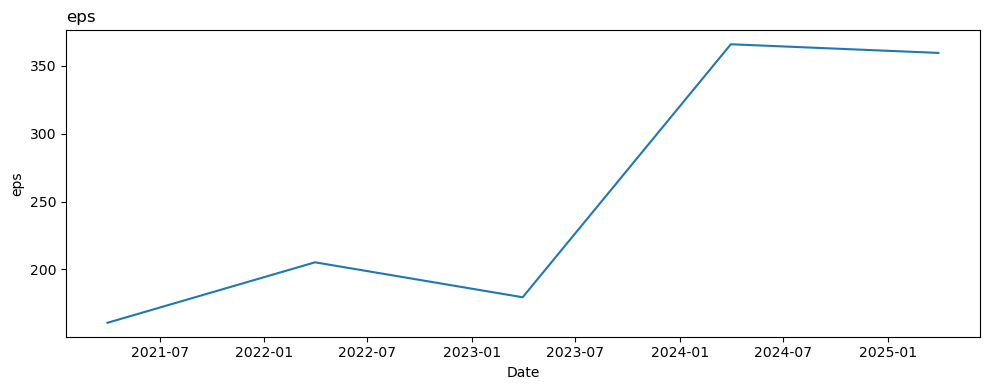

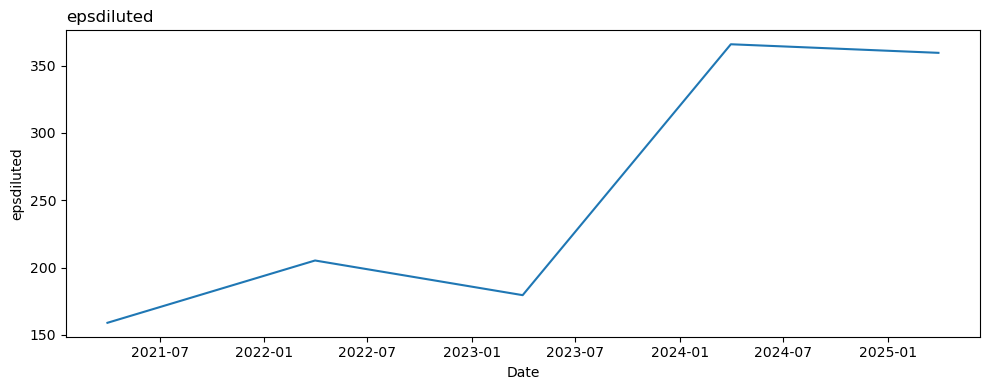

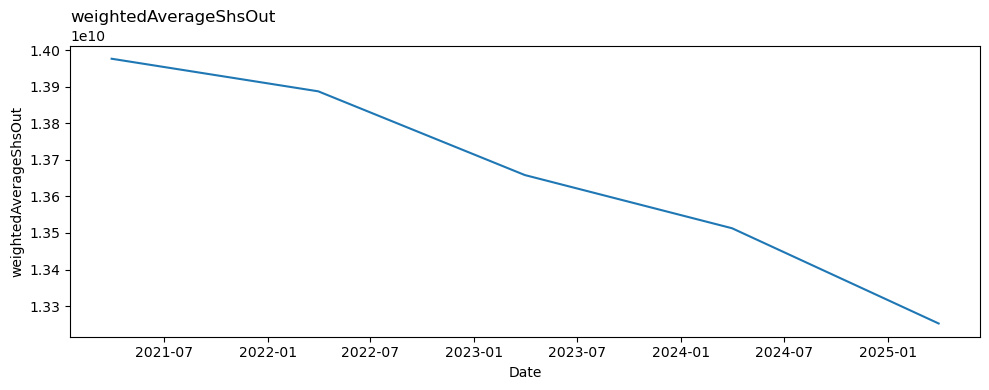

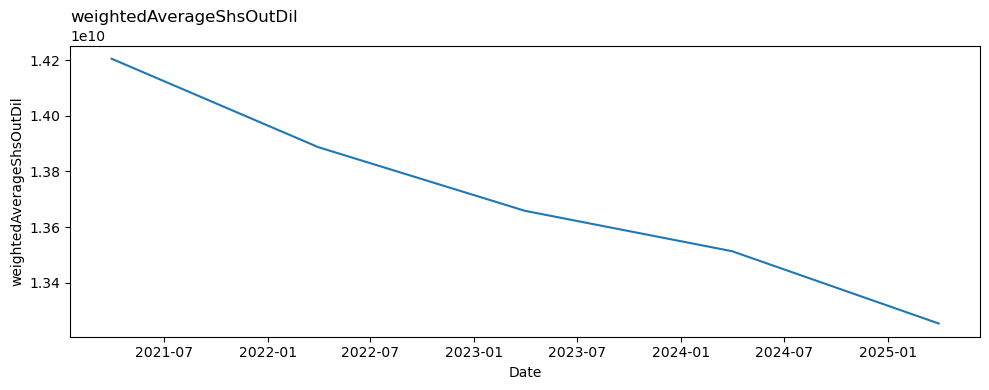

In [63]:
#───────────────────────────────────────────────────────────
# Time-series plots for every numeric column in `df`
#───────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

# 1 ▸ index & sort
df_ts = df.copy()
df_ts["date"] = pd.to_datetime(df_ts["date"])
df_ts = df_ts.sort_values("date").set_index("date")

# 2 ▸ numeric columns only
numeric_cols = df_ts.select_dtypes(include="number").columns

print(f"Plotting {len(numeric_cols)} numeric features…")

# 3 ▸ one figure per feature
for col in numeric_cols:
    plt.figure(figsize=(10, 4))
    plt.plot(df_ts.index, df_ts[col])
    plt.title(col, loc="left")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()
